In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import numpy as np
from matplotlib.lines import Line2D
# plt.rcParams["figure.figsize"] = (20,20)
# plt.rcParams.update({'font.size': 28})

plt.rcParams['text.usetex'] = True

In [2]:
def format_scientific_notation_with_superscript(value):

    # Convert to scientific notation
    scientific_notation = f"{value:.1e}"
    # Split the scientific notation string into mantissa and exponent parts
    mantissa, exponent = scientific_notation.split('e')
    # Format the exponent to remove the leading + and convert it to superscript
    exponent = exponent.replace('+', '')
    exponent = str(int(exponent))
    return fr"${mantissa}\times10^{{ {exponent} }}$"
    # return r'$\times$'

In [3]:



# "results/frontera-scaling-updated-ghost-dist-filter___2024-05-30__17-46-26.json"

input_file_name = 'results/frontera-scaling-front_bfs-large-meshes___2024-06-19__16-10-43.json'

# input_file_name = 'results/frontera-scaling-overlapped-com___2024-06-20__19-27-55.json'     # current best

# input_file_name = 'results/frontera-scaling-front_bfs___2024-06-06__19-42-12.json'   

prev_file = 'results/frontera-scaling-front_bfs___2024-06-06__19-42-12.json'


# prev_file = "results/frontera-scaling-front_bfs___2024-05-30__19-10-01.json"

# 'results/frontera-scaling-front_bfs___2024-06-06__19-42-12.json'     # last shown to Hari


# prev_file = "results/frontera-scaling-std-bfs-dist-filter-changed-ghost-types-32-32-16___2024-05-28__18-33-13.json"     

input_file_name = "test.json"



In [4]:
df = pd.read_json(input_file_name, orient='records',lines=True)
# print(df)
# df = df[df['run_idx'] == 2] 
df.reset_index(drop=True, inplace=True)
mesh_count = df['mesh_idx'].max() + 1
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']




df_prev = pd.read_json(prev_file, orient='records',lines=True)

df_prev.reset_index(drop=True, inplace=True)

In [5]:
# getting aggregated data

df_all = df.copy()

extracted_fields = ['mesh_idx','n','np',
                    'SFC_morton_partition_time', 'SFC_morton_mat_assembly_time', 'SFC_morton_matvec_time',
                    'BFS_labeling_time','BFS_redistribution_time', 'BFS_mat_assembly_time', 'BFS_matvec_time',
                    'parMETIS_labeling_time', 'parMETIS_redistribution_time', 'parMETIS_mat_assembly_time', 'parMETIS_matvec_time']

df = df[extracted_fields]

extracted_fields2 = extracted_fields[::]
extracted_fields2.remove('np')
extracted_fields2.remove('mesh_idx')


df = df.groupby(['mesh_idx','np'])[extracted_fields2].min().reset_index()           # min or avg




# df_prev_all = df_prev.copy()

# df_prev = df_prev[['mesh_idx','n','np','BFS_labeling_time','parMETIS_labeling_time']]

# df_prev = df_prev.groupby(['mesh_idx','np'])[['n','BFS_labeling_time','parMETIS_labeling_time']].min().reset_index()           # min or avg

Text(0.5, 0.98, 'partition labeling time - strong scaling')

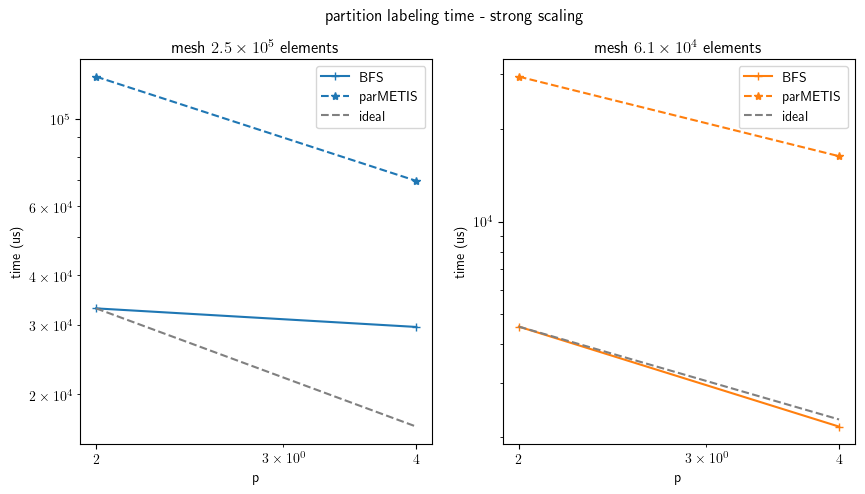

In [12]:

# plt.figure()

fig, axs = plt.subplots(1, mesh_count, figsize=(5*mesh_count, 5)) 
# fig, axs = plt.subplots(1, mesh_count, figsize=(5*mesh_count, 5)) 

if not isinstance(axs, np.ndarray):
    axs = [axs]

for mesh_idx in range(mesh_count):
    # if(mesh_idx == 1):
    #     continue

    filtered_df = df[df['mesh_idx'] == mesh_idx].copy()
    filtered_df.reset_index(drop=True, inplace=True)
    element_count = filtered_df.loc[0, 'n']


    # filtered_df_prev = df_prev[df_prev['mesh_idx'] == mesh_idx].copy()
    # filtered_df_prev.reset_index(drop=True, inplace=True)
    


    # plt.figure()
    axs[mesh_idx].plot(filtered_df['np'], filtered_df['BFS_labeling_time'],color=colors[mesh_idx], label=f"BFS", marker='+',)
    axs[mesh_idx].plot(filtered_df['np'], filtered_df['parMETIS_labeling_time'],color=colors[mesh_idx], label=f"parMETIS", marker='*', linestyle='--')
    
    # axs[mesh_idx].plot(filtered_df_prev['np'], filtered_df_prev['BFS_time'],color='black', label=f"BFS (prev impl.)", marker='+',)


    # plotting ideal scaling for BFS
    min_proc_count = filtered_df['np'].min()
    min_proc_BFS_time = filtered_df[filtered_df['np'] == min_proc_count].loc[0,'BFS_labeling_time']
    filtered_df['BFS_time_ideal_scaling'] = min_proc_BFS_time * (min_proc_count/filtered_df['np'])

    axs[mesh_idx].plot(filtered_df['np'], filtered_df['BFS_time_ideal_scaling'],color='grey', label=f"ideal", marker='', linestyle='--')


    df_all_filtered = df_all[df_all['mesh_idx'] == mesh_idx]



    # plotting individual data points
    # axs[mesh_idx].scatter(df_all_filtered['np'], df_all_filtered['BFS_labeling_time'], color=colors[mesh_idx], marker='+', alpha=0.5, label='BFS data')
    # axs[mesh_idx].scatter(df_all_filtered['np'], df_all_filtered['METIS_time'], color=colors[mesh_idx], marker='*', alpha=0.5, label='parMETIS data')



    
    axs[mesh_idx].set_xscale('log')
    axs[mesh_idx].set_yscale('log')
    axs[mesh_idx].set_xticks(filtered_df['np'])
    axs[mesh_idx].get_xaxis().set_major_formatter(ScalarFormatter())
    axs[mesh_idx].set_title("mesh   "+   format_scientific_notation_with_superscript(element_count)+ " elements")
    axs[mesh_idx].set_xlabel('p')
    axs[mesh_idx].set_ylabel('time (us)')

    # ## Annotate each point with its y value
    # for i in range(len(filtered_df)):
    #     axs[mesh_idx].annotate(format_scientific_notation_with_superscript(filtered_df["BFS_time"][i]), (filtered_df['np'][i], filtered_df['BFS_time'][i]), textcoords="offset points", xytext=(0,5), ha='center')
    #     axs[mesh_idx].annotate(format_scientific_notation_with_superscript(filtered_df["METIS_time"][i]), (filtered_df['np'][i], filtered_df['METIS_time'][i]), textcoords="offset points", xytext=(0,5), ha='center')



    axs[mesh_idx].legend()
fig.suptitle('partition labeling time - strong scaling')

Text(0.5, 0.98, 'partition total (label+redistribution) time - strong scaling')

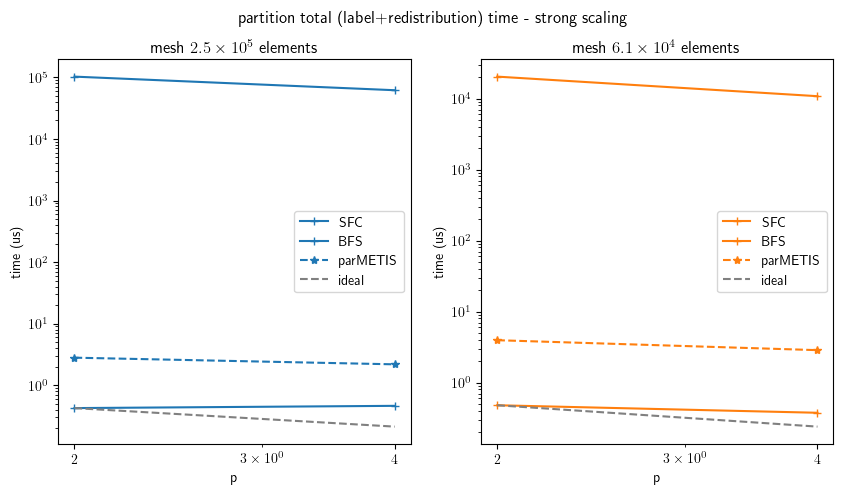

In [14]:
fig, axs = plt.subplots(1, mesh_count, figsize=(5*mesh_count, 5)) 

if not isinstance(axs, np.ndarray):
    axs = [axs]

for mesh_idx in range(mesh_count):

    filtered_df = df[df['mesh_idx'] == mesh_idx].copy()
    filtered_df.reset_index(drop=True, inplace=True)
    filtered_df['BFS_total_time'] = filtered_df['BFS_labeling_time'] / + filtered_df['BFS_redistribution_time']
    filtered_df['parMETIS_total_time'] = filtered_df['parMETIS_labeling_time'] / + filtered_df['parMETIS_redistribution_time']

    
    element_count = filtered_df.loc[0, 'n']


    axs[mesh_idx].plot(filtered_df['np'], filtered_df['SFC_morton_partition_time'],color=colors[mesh_idx], label=f"SFC", marker='+',)

    axs[mesh_idx].plot(filtered_df['np'], filtered_df['BFS_total_time'],color=colors[mesh_idx], label=f"BFS", marker='+',)
    axs[mesh_idx].plot(filtered_df['np'], filtered_df['parMETIS_total_time'],color=colors[mesh_idx], label=f"parMETIS", marker='*', linestyle='--')
    
    # axs[mesh_idx].plot(filtered_df_prev['np'], filtered_df_prev['BFS_time'],color='black', label=f"BFS (prev impl.)", marker='+',)


    # plotting ideal scaling for BFS
    min_proc_count = filtered_df['np'].min()
    min_proc_BFS_time = filtered_df[filtered_df['np'] == min_proc_count].loc[0,'BFS_total_time']
    filtered_df['BFS_total_time_ideal_scaling'] = min_proc_BFS_time * (min_proc_count/filtered_df['np'])

    axs[mesh_idx].plot(filtered_df['np'], filtered_df['BFS_total_time_ideal_scaling'],color='grey', label=f"ideal", marker='', linestyle='--')


    # df_all_filtered = df_all[df_all['mesh_idx'] == mesh_idx]
   
    axs[mesh_idx].set_xscale('log')
    axs[mesh_idx].set_yscale('log')
    axs[mesh_idx].set_xticks(filtered_df['np'])
    axs[mesh_idx].get_xaxis().set_major_formatter(ScalarFormatter())
    axs[mesh_idx].set_title("mesh   "+   format_scientific_notation_with_superscript(element_count)+ " elements")
    axs[mesh_idx].set_xlabel('p')
    axs[mesh_idx].set_ylabel('time (us)')



    axs[mesh_idx].legend()
fig.suptitle('partition total (label+redistribution) time - strong scaling')

Text(0.5, 0.98, 'SpMV Matrix Assemble Time - strong scaling')

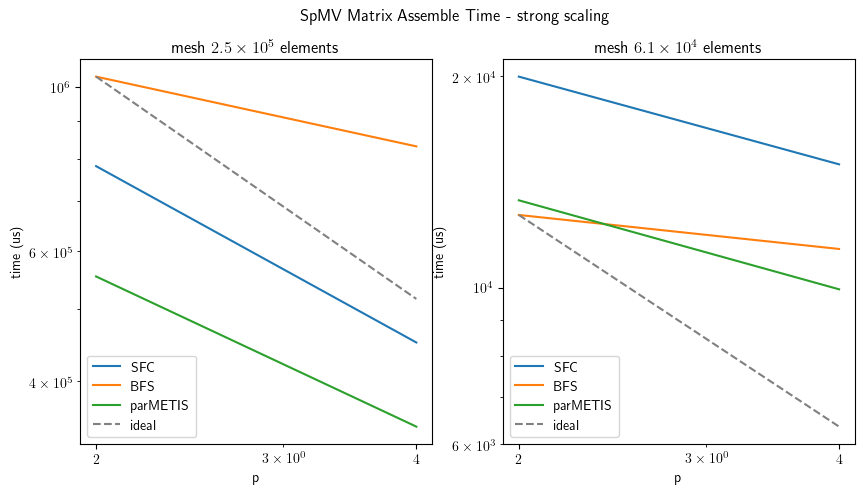

In [15]:
fig, axs = plt.subplots(1, mesh_count, figsize=(5*mesh_count, 5)) 

if not isinstance(axs, np.ndarray):
    axs = [axs]

for mesh_idx in range(mesh_count):

    filtered_df = df[df['mesh_idx'] == mesh_idx].copy()
    filtered_df.reset_index(drop=True, inplace=True)
    
    element_count = filtered_df.loc[0, 'n']


    axs[mesh_idx].plot(filtered_df['np'], filtered_df['SFC_morton_mat_assembly_time'],color=colors[0], label=f"SFC")

    axs[mesh_idx].plot(filtered_df['np'], filtered_df['BFS_mat_assembly_time'],color=colors[1], label=f"BFS")
    axs[mesh_idx].plot(filtered_df['np'], filtered_df['parMETIS_mat_assembly_time'],color=colors[2], label=f"parMETIS")
    

    # plotting ideal scaling for BFS_mat_assembly_time
    min_proc_count = filtered_df['np'].min()
    min_proc_BFS_time = filtered_df[filtered_df['np'] == min_proc_count].loc[0,'BFS_mat_assembly_time']
    filtered_df['BFS_mat_assembly_time_ideal_scaling'] = min_proc_BFS_time * (min_proc_count/filtered_df['np'])

    axs[mesh_idx].plot(filtered_df['np'], filtered_df['BFS_mat_assembly_time_ideal_scaling'],color='grey', label=f"ideal", marker='', linestyle='--')


    # df_all_filtered = df_all[df_all['mesh_idx'] == mesh_idx]
   
    axs[mesh_idx].set_xscale('log')
    axs[mesh_idx].set_yscale('log')
    axs[mesh_idx].set_xticks(filtered_df['np'])
    axs[mesh_idx].get_xaxis().set_major_formatter(ScalarFormatter())
    axs[mesh_idx].set_title("mesh   "+   format_scientific_notation_with_superscript(element_count)+ " elements")
    axs[mesh_idx].set_xlabel('p')
    axs[mesh_idx].set_ylabel('time (us)')



    axs[mesh_idx].legend()

fig.suptitle('SpMV Matrix Assemble Time - strong scaling')

Text(0.5, 0.98, 'SpMV MatVec Time - strong scaling')

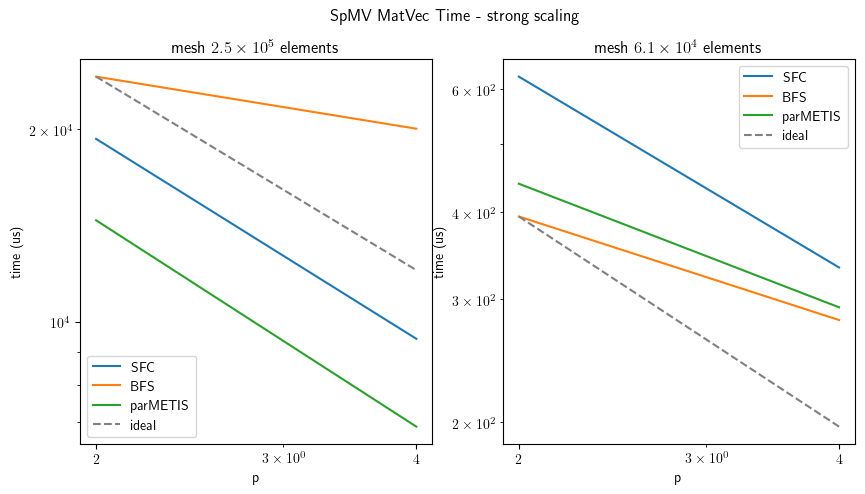

In [16]:
fig, axs = plt.subplots(1, mesh_count, figsize=(5*mesh_count, 5)) 

if not isinstance(axs, np.ndarray):
    axs = [axs]

for mesh_idx in range(mesh_count):

    filtered_df = df[df['mesh_idx'] == mesh_idx].copy()
    filtered_df.reset_index(drop=True, inplace=True)
    
    element_count = filtered_df.loc[0, 'n']


    axs[mesh_idx].plot(filtered_df['np'], filtered_df['SFC_morton_matvec_time'],color=colors[0], label=f"SFC")

    axs[mesh_idx].plot(filtered_df['np'], filtered_df['BFS_matvec_time'],color=colors[1], label=f"BFS")
    axs[mesh_idx].plot(filtered_df['np'], filtered_df['parMETIS_matvec_time'],color=colors[2], label=f"parMETIS")
    

    # plotting ideal scaling for BFS_mat_assembly_time
    min_proc_count = filtered_df['np'].min()
    min_proc_BFS_time = filtered_df[filtered_df['np'] == min_proc_count].loc[0,'BFS_matvec_time']
    filtered_df['BFS_matvec_time_ideal_scaling'] = min_proc_BFS_time * (min_proc_count/filtered_df['np'])

    axs[mesh_idx].plot(filtered_df['np'], filtered_df['BFS_matvec_time_ideal_scaling'],color='grey', label=f"ideal", marker='', linestyle='--')


    # df_all_filtered = df_all[df_all['mesh_idx'] == mesh_idx]
   
    axs[mesh_idx].set_xscale('log')
    axs[mesh_idx].set_yscale('log')
    axs[mesh_idx].set_xticks(filtered_df['np'])
    axs[mesh_idx].get_xaxis().set_major_formatter(ScalarFormatter())
    axs[mesh_idx].set_title("mesh   "+   format_scientific_notation_with_superscript(element_count)+ " elements")
    axs[mesh_idx].set_xlabel('p')
    axs[mesh_idx].set_ylabel('time (us)')



    axs[mesh_idx].legend()
fig.suptitle('SpMV MatVec Time - strong scaling')


In [10]:
# fig, axs = plt.subplots(1, 1, figsize=(7, 7))  
# for mesh_idx in range(mesh_count):
#     filtered_df = df[df['mesh_idx'] == mesh_idx]
#     filtered_df.reset_index(drop=True, inplace=True)
#     element_count = filtered_df.loc[0, 'n']
#     # plt.figure()
#     axs.plot(filtered_df['np'], filtered_df['BFS_labeling_time'],color=colors[mesh_idx], label=f"BFS", marker='o',)
#     axs.plot(filtered_df['np'], filtered_df['parMETIS_labeling_time'],color=colors[mesh_idx], label=f"parMETIS", marker='o', linestyle='--')
# legend_elements = [
#     Line2D([0], [0], color='black', label='BFS',marker='o'),
#     Line2D([0], [0], color='black', label='parMETIS',marker='o', linestyle='--')
# ]

# axs.set_xscale('log')
# axs.set_yscale('log')
# plt.xticks(filtered_df['np'])
# plt.gca().xaxis.set_major_formatter(ScalarFormatter())
# axs.set_title(f"strong scaling")
# axs.set_xlabel('p')
# axs.set_ylabel('time (us)')
# axs.legend(handles=legend_elements)
# axs.legend()

In [11]:
# # Define conditions
# conditions = [
#     (df['mesh_idx'] == 0) & (df['np'] == 1280),
#     (df['mesh_idx'] == 1) & (df['np'] == 640),
#     (df['mesh_idx'] == 2) & (df['np'] == 320),
#     (df['mesh_idx'] == 3) & (df['np'] == 160),
#     (df['mesh_idx'] == 4) & (df['np'] == 80),
#     (df['mesh_idx'] == 5) & (df['np'] == 40),


# ]



# # Filter the DataFrame for each condition
# filtered_dfs = [df[cond] for cond in conditions]
# filtered_df = pd.concat(filtered_dfs)

# # print(filtered_df)
# filtered_df.reset_index(drop=True, inplace=True)
# weak_scaling_adjust_factor = filtered_df.loc[5, 'n']/ filtered_df.loc[5, 'np']
# # print(weak_scaling_adjust_factor)
# filtered_df['BFS_time_adjusted'] = filtered_df['BFS_time'] / ((filtered_df['n']/filtered_df['np']) / weak_scaling_adjust_factor)
# filtered_df['METIS_time_adjusted'] = filtered_df['METIS_time'] / ((filtered_df['n']/filtered_df['np']) / weak_scaling_adjust_factor)
# print(filtered_df[['np', 'n', 'BFS_time', 'BFS_time_adjusted','METIS_time', 'METIS_time_adjusted']])

# plt.plot(filtered_df['np'], filtered_df['BFS_time_adjusted'],color='red', label=f"BFS", marker='o',)
# plt.plot(filtered_df['np'], filtered_df['METIS_time_adjusted'],color='red', label=f"parMETIS", marker='o', linestyle='--')



# plt.xscale('log')
# plt.yscale('log')

# plt.xticks(filtered_df['np'])
# plt.gca().xaxis.set_major_formatter(ScalarFormatter())

# plt.xlabel('p')
# plt.ylabel('time (us)')
# plt.title('weak scaling \n' r' $\frac{n}{p} \approx 1500$ ')
# plt.legend()
# plt.show()

# # print(list(filtered_df['mesh_file']))